# Modulok és Dataprep

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_excel("C:/Users/Donát/Documents/GitHub/-nkutfel/2019/2019_MAIN_CLEANED.xlsx")

**Minimális Feature Engineering**

In [3]:
#szűrjük ki a nem kategorikus vagy numerikus változókat
working_data = data.drop(labels = ["Name", "Neptun", "Tankör"], axis = 1)

#alakítsuk numerikussá a %-os teljesítménymutatókat
for i, row in working_data.iterrows():
    working_data.at[i, "Matek eredmény"] = float(row["Matek eredmény"][:-3] + "." + row["Matek eredmény"][-2])
    working_data.at[i, "Kognitív eredmény"] = float(row["Kognitív eredmény"][:-3] + "." + row["Kognitív eredmény"][-2])
    working_data.at[i, "Kognitív pont"] = float(str(row["Kognitív pont"]).replace(",", "."))
    working_data.at[i, "Össz eredmény (átlag)"] = float(row["Össz eredmény (átlag)"][:-3] + "." + row["Össz eredmény (átlag)"][-2])



In [4]:
#csináljunk a jegyek alapján 3 csoportot: a jó tanulók a 4-5, a rossz a 2-3, a bukás legyen 1
for i, row in working_data.iterrows():
    if working_data.at[i, "Matematika A1a - Analízis"] in [ 4, 5]:
        working_data.at[i, "Matematika A1a - Analízis"] = 3
    elif working_data.at[i, "Matematika A1a - Analízis"] in [2, 3]:
        working_data.at[i, "Matematika A1a - Analízis"] = 2

In [5]:
working_data['Matematika A1a - Analízis'].value_counts()

2    145
3     80
1      5
Name: Matematika A1a - Analízis, dtype: int64

# Vegyészek

In [6]:
from imblearn.over_sampling import SMOTE

vegyesz = working_data.query("Szak == 'Vegyészmérnöki'")

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = vegyesz.drop(labels = ["Matematika A1a - Analízis", "Kognitív pont", "Matematika A2c", "Szak", "Matek helyes", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = vegyesz["Matematika A1a - Analízis"]



X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warnings.warn(


## Osztályozó algoritmusok

**KNN**

In [7]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mahalanobis kNN:
{'cv_score': 0.65, 'test_score': 0.8055555555555556}
Params:
{'classifier__n_neighbors': 13, 'classifier__weights': 'uniform'}


In [8]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Euclidian kNN:
{'cv_score': 0.6742647058823529, 'test_score': 0.7777777777777778}
Params:
{'classifier__n_neighbors': 21, 'classifier__weights': 'uniform'}


In [9]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 13, 'classifier__weights': 'uniform'} 
- Accuracy: 0.8055555555555556
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 21, 'classifier__weights': 'uniform'} 
- Accuracy: 0.7777777777777778


**SVM**

In [10]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),4)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),4)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),4)}')



D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


SVM:
{'cv_score': 0.65, 'test_score': 0.6944444444444444}
Params:
{'classifier__C': 0.4, 'classifier__kernel': 'rbf'}

Accuracy: 0.6944
Precision: 0.738
Recall: 0.6944


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Logisztikus Regresszió**

In [11]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),4)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),4)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),4)}')


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Logistic Regression:
{'cv_score': 0.6257352941176471, 'test_score': 0.0}
Params:
{'classifier__C': 0.05, 'classifier__solver': 'sag'}

Accuracy: 0.0
Precision: 0.0
Recall: 0.0


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Naive Bayes**

In [12]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),4)}')

Accuracy: 0.7778


In [13]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.6944444444444444 
- Logistic Regression: 0.0 
- Naive Bayes: 0.7778


**Gradient Boosting**

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),4)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),4)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),4)}')

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Gradient Boosting:
{'cv_score': 0.5897058823529412, 'test_score': 0.5555555555555556}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.48, 'classifier__max_depth': 5, 'classifier__n_estimators': 10}

Accuracy: 0.5556
Precision: 0.5915
Recall: 0.5556


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Lineáris regresszió**

In [15]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.30548415287416486

In [16]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
print("RMSE:", rmse)

Coefficients: [ 0.07988749  0.1902731  -0.06149958 -0.27607194 -0.26341137  0.79916553
  0.14761117  0.19872182  0.1184327  -0.07157714  0.04357576]
RMSE: 0.3898


<function matplotlib.pyplot.show(close=None, block=None)>

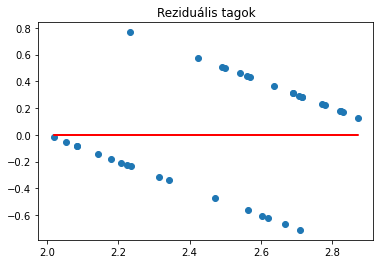

In [17]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [18]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,4)
R2

0.2622

In [19]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),4))

RMSE: 0.5
0.75


In [20]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.3898 
- R2: 0.2622 
- RMSE after rounding: 0.5 
- Accuracy after rounding: 0.75


### Eredmények összesítve

In [21]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 13, 'classifier__weights': 'uniform'} 
- Accuracy: 0.8055555555555556
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 21, 'classifier__weights': 'uniform'} 
- Accuracy: 0.7777777777777778
SVM:
- Accuracy: 0.6944444444444444
Logistic Regression:
- Accuracy: 0.0
Naive Bayes:
- Accuracy: 0.7778
Linear regression:
- RMSE: 0.3898 
- R2: 0.2622 
- RMSE after rounding: 0.5 
- Accuracy after rounding: 0.75


# PCA

In [22]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.56, 0.67, 0.58, 0.81, 0.75, 0.81, 0.69, 0.83, 0.83]

In [23]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.86
Precision: 0.6
Recall: 0.57


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warn

In [25]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.5556,0.8333,0.0000,0.6944,0.3697,0.1945,0.4410,0.8056
1,2,0.8056,0.8333,0.8056,0.6667,0.3877,0.2041,0.4082,0.8333
2,3,0.7500,0.8333,0.0000,0.6667,0.3802,0.2164,0.4082,0.8333
3,4,0.7500,0.8333,0.0278,0.8611,0.3829,0.2186,0.4410,0.8056
4,5,0.8333,0.8056,0.6944,0.6667,0.3805,0.2182,0.4410,0.8056
5,6,0.8611,0.8333,0.8056,0.7500,0.3771,0.2153,0.3727,0.8611
6,7,0.7222,0.7778,0.0556,0.7778,0.3765,0.2169,0.3727,0.8611
7,8,0.8333,0.8056,0.1389,0.7778,0.3771,0.2309,0.4410,0.8056


# Biomérnökök

In [26]:
from imblearn.over_sampling import SMOTE

biom = working_data.query("Szak == 'Biomérnöki'")

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = biom.drop(labels = ["Matematika A1a - Analízis", "Matematika A2c", "Kognitív pont", "Szak", "Matek helyes", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = biom["Matematika A1a - Analízis"]



X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (56). n_quantiles is set to n_samples.
  warnings.warn(


## Osztályozó algoritmusok

**KNN**

In [27]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mahalanobis kNN:
{'cv_score': 0.7681818181818183, 'test_score': 0.76}
Params:
{'classifier__n_neighbors': 8, 'classifier__weights': 'uniform'}


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.54848485 0.54848485 0.54848485 0.65909091 0.54848485 0.54848485
 0.73181818 0.73181818 0.73181818 0.75       0.73181818 0.73181818
 0.75       0.73181818 0.73181818 0.75       0.71363636 0.71363636
 0.71363636 0.71363636 0.69545455 0.76818182 0.71363636 0.69545455
 0.75       0.75       0.73181818 0.76818182 0.73181818 0.71363636
 0.76818182 0.76818182 0.75       0.76818182 0.76818182 0.75
 0.76818182 0.76818182 0.75       0.76818182 0.76818182 0.75
 0.76818182 0.76818182 0.75       0.76818182 0.76818182 0.75
 0.76818182 0.76818182 0.75       0.76818182 0.76818182 0.75
 0.76818182 0.76818182 0.75       0.76818182 0.76818182 0.75
 0.76818182 0.76818182 0.75              nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan    

In [28]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Euclidian kNN:
{'cv_score': 0.7863636363636365, 'test_score': 0.72}
Params:
{'classifier__n_neighbors': 4, 'classifier__weights': 'uniform'}


In [29]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 8, 'classifier__weights': 'uniform'} 
- Accuracy: 0.76
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 4, 'classifier__weights': 'uniform'} 
- Accuracy: 0.72


**SVM**

In [30]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


SVM:
{'cv_score': 0.6969696969696969, 'test_score': 0.52}
Params:
{'classifier__C': 0.2, 'classifier__kernel': 'poly'}

Accuracy: 0.52
Precision: 0.6
Recall: 0.52


**Logisztikus Regresszió**

In [31]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Logistic Regression:
{'cv_score': 0.5909090909090909, 'test_score': 0.04}
Params:
{'classifier__C': 0.35000000000000003, 'classifier__solver': 'sag'}

Accuracy: 0.04
Precision: 0.0
Recall: 0.04


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Naive Bayes**

In [32]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.72


In [33]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.52 
- Logistic Regression: 0.04 
- Naive Bayes: 0.72


**Gradient Boosting**

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Gradient Boosting:
{'cv_score': 0.787878787878788, 'test_score': 0.68}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.02, 'classifier__max_depth': 3, 'classifier__n_estimators': 45}

Accuracy: 0.68
Precision: 0.63
Recall: 0.68


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Lineáris regresszió**

In [35]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.2350570590869514

In [36]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [-0.03523787  0.57234015 -0.27212682 -0.15299126  0.03495037  0.99162783
 -0.43771988 -0.28168797  0.01567409  0.11269201  0.02314072]
RMSE: 0.53


<function matplotlib.pyplot.show(close=None, block=None)>

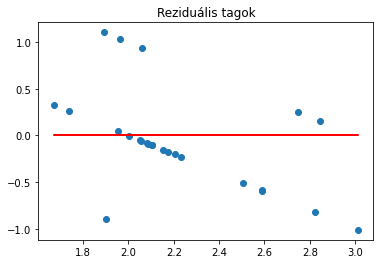

In [37]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [38]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.59

In [39]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.6
0.64


In [40]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.53 
- R2: 0.59 
- RMSE after rounding: 0.6 
- Accuracy after rounding: 0.64


### Eredmények összesítve

In [41]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 8, 'classifier__weights': 'uniform'} 
- Accuracy: 0.76
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 4, 'classifier__weights': 'uniform'} 
- Accuracy: 0.72
SVM:
- Accuracy: 0.52
Logistic Regression:
- Accuracy: 0.04
Naive Bayes:
- Accuracy: 0.72
Linear regression:
- RMSE: 0.53 
- R2: 0.59 
- RMSE after rounding: 0.6 
- Accuracy after rounding: 0.64


# PCA

In [42]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.76, 0.8, 0.76, 0.72, 0.76, 0.76, 0.76, 0.76, 0.76]

In [43]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.4
Precision: 0.37
Recall: 0.29


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (56). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
D:\anaconda3\envs\ottho

In [45]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.76,0.76,0.00,0.40,0.4280,0.1136,0.4899,0.76
1,2,0.76,0.76,0.64,0.64,0.4277,0.1082,0.4899,0.76
2,3,0.76,0.76,0.68,0.76,0.4261,0.1523,0.4899,0.76
3,4,0.76,0.76,0.16,0.64,0.4263,0.1854,0.4899,0.76
4,5,0.76,0.76,0.48,0.72,0.4264,0.1855,0.4899,0.76
5,6,0.76,0.76,0.12,0.68,0.4233,0.1365,0.4899,0.76
6,7,0.76,0.76,0.52,0.72,0.4304,0.1828,0.4899,0.76
7,8,0.76,0.76,0.52,0.72,0.4416,0.2002,0.4899,0.76


# Modulok és Dataprep

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

In [47]:
data = pd.read_excel("C:/Users/Donát/Documents/GitHub/-nkutfel/2019/2019_MAIN_CLEANED.xlsx")

**Minimális Feature Engineering**

In [48]:
#szűrjük ki a nem kategorikus vagy numerikus változókat
working_data = data.drop(labels = ["Name", "Neptun", "Tankör"], axis = 1)

#alakítsuk numerikussá a %-os teljesítménymutatókat
for i, row in working_data.iterrows():
    working_data.at[i, "Matek eredmény"] = float(row["Matek eredmény"][:-3] + "." + row["Matek eredmény"][-2])
    working_data.at[i, "Kognitív eredmény"] = float(row["Kognitív eredmény"][:-3] + "." + row["Kognitív eredmény"][-2])
    working_data.at[i, "Kognitív pont"] = float(str(row["Kognitív pont"]).replace(",", "."))
    working_data.at[i, "Össz eredmény (átlag)"] = float(row["Össz eredmény (átlag)"][:-3] + "." + row["Össz eredmény (átlag)"][-2])



In [49]:
#csináljunk a jegyek alapján 3 csoportot: a jó tanulók a 4-5, a rossz a 2-3, a bukás legyen 1
for i, row in working_data.iterrows():
    if working_data.at[i, "Matematika A1a - Analízis"] in [3, 4, 5]:
        working_data.at[i, "Matematika A1a - Analízis"] = 1
    elif working_data.at[i, "Matematika A1a - Analízis"] in [2, 1]:
        working_data.at[i, "Matematika A1a - Analízis"] = 0

In [50]:
working_data['Matematika A1a - Analízis'].value_counts()

1    155
0     75
Name: Matematika A1a - Analízis, dtype: int64

# Vegyészek

In [51]:
from imblearn.over_sampling import SMOTE

vegyesz = working_data.query("Szak == 'Vegyészmérnöki'")

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = vegyesz.drop(labels = ["Matematika A1a - Analízis", "Kognitív pont", "Matematika A2c", "Szak", "Matek helyes", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = vegyesz["Matematika A1a - Analízis"]



X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warnings.warn(


## Osztályozó algoritmusok

**KNN**

In [52]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.7720588235294118, 'test_score': 0.8055555555555556}
Params:
{'classifier__n_neighbors': 18, 'classifier__weights': 'uniform'}


In [53]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.7823529411764706, 'test_score': 0.8333333333333334}
Params:
{'classifier__n_neighbors': 8, 'classifier__weights': 'uniform'}


In [54]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 18, 'classifier__weights': 'uniform'} 
- Accuracy: 0.8055555555555556
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 8, 'classifier__weights': 'uniform'} 
- Accuracy: 0.8333333333333334


**SVM**

In [55]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.7595588235294117, 'test_score': 0.8055555555555556}
Params:
{'classifier__C': 4.2, 'classifier__kernel': 'poly'}

Accuracy: 0.81
Precision: 0.8
Recall: 0.81


**Logisztikus Regresszió**

In [56]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.7580882352941176, 'test_score': 0.7222222222222222}
Params:
{'classifier__C': 1.1500000000000001, 'classifier__solver': 'sag'}

Accuracy: 0.72
Precision: 0.77
Recall: 0.72


**Naive Bayes**

In [57]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.78


In [58]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.8055555555555556 
- Logistic Regression: 0.7222222222222222 
- Naive Bayes: 0.78


**Gradient Boosting**

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.7823529411764707, 'test_score': 0.7777777777777778}
Params:
{'classifier__criterion': 'friedman_mse', 'classifier__learning_rate': 0.49, 'classifier__max_depth': 5, 'classifier__n_estimators': 35}

Accuracy: 0.78
Precision: 0.76
Recall: 0.78


**Lineáris regresszió**

In [60]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.403179324584537

In [61]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [-0.0099283  -0.00590125 -0.17114641 -0.75949878 -0.1262394   1.27462848
  0.12312862  0.18541336  0.45029807 -0.10670399  0.04722161]
RMSE: 0.34


<function matplotlib.pyplot.show(close=None, block=None)>

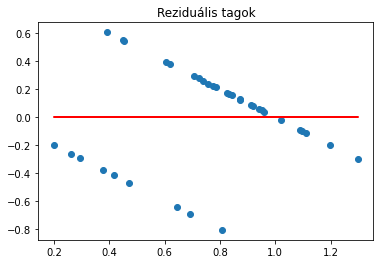

In [62]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [63]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.39

In [64]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.41
0.83


In [65]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.34 
- R2: 0.39 
- RMSE after rounding: 0.41 
- Accuracy after rounding: 0.83


### Eredmények összesítve

In [66]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 18, 'classifier__weights': 'uniform'} 
- Accuracy: 0.8055555555555556
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 8, 'classifier__weights': 'uniform'} 
- Accuracy: 0.8333333333333334
SVM:
- Accuracy: 0.8055555555555556
Logistic Regression:
- Accuracy: 0.7222222222222222
Naive Bayes:
- Accuracy: 0.78
Linear regression:
- RMSE: 0.34 
- R2: 0.39 
- RMSE after rounding: 0.41 
- Accuracy after rounding: 0.83


# PCA

In [67]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.81, 0.67, 0.64, 0.67, 0.67, 0.72, 0.72, 0.72, 0.72]

In [68]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.75
Precision: 0.7
Recall: 0.73


In [69]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (83). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of

In [70]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.7222,0.7500,0.8333,0.7500,0.3848,0.3045,0.5270,0.7222
1,2,0.7500,0.7500,0.7500,0.7222,0.3994,0.2898,0.5270,0.7222
2,3,0.7500,0.6944,0.7500,0.7778,0.3977,0.3508,0.5270,0.7222
3,4,0.6944,0.6944,0.7500,0.7500,0.3995,0.3466,0.5774,0.6667
4,5,0.7500,0.6944,0.7500,0.7500,0.3991,0.3465,0.5774,0.6667
5,6,0.7222,0.7500,0.7500,0.7222,0.3943,0.3377,0.5270,0.7222
6,7,0.7500,0.7778,0.6667,0.7500,0.4001,0.3169,0.4410,0.8056
7,8,0.7500,0.8056,0.6667,0.7778,0.4026,0.3723,0.4714,0.7778


# Biomérnökök

In [71]:
from imblearn.over_sampling import SMOTE

biom = working_data.query("Szak == 'Biomérnöki'")

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

features = biom.drop(labels = ["Matematika A1a - Analízis", "Matematika A2c", "Szak","Kognitív pont", "Matek helyes", "Összes pont", "Össz eredmény (átlag)"], axis = 1)
label = biom["Matematika A1a - Analízis"]



X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=0, stratify=label)


#skálázás

from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (56). n_quantiles is set to n_samples.
  warnings.warn(


## Osztályozó algoritmusok

**KNN**

In [72]:
#KNN-re keresztvalidációval mahalanobis-szal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


#distance függvény
def squared(array):
    return 1/array**2



pipeline = imbpipeline(steps = [['classifier', KNeighborsClassifier(metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_mahal_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_mahal_grid_search.fit(X_train, y_train)
cv_score = knn_mahal_grid_search.best_score_
knn_mahal = knn_mahal_grid_search.score(X_test, y_test)
print("Mahalanobis kNN:")
print({'cv_score':cv_score, 'test_score':knn_mahal})
print("Params:")
print(knn_mahal_grid_search.best_params_)


Mahalanobis kNN:
{'cv_score': 0.6621212121212121, 'test_score': 0.6}
Params:
{'classifier__n_neighbors': 13, 'classifier__weights': 'uniform'}


D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.51818182 0.51818182 0.51818182 0.48484848 0.51818182 0.51818182
 0.57272727 0.57272727 0.51969697 0.53787879 0.55606061 0.55606061
 0.55       0.55       0.53333333 0.56818182 0.56969697 0.56969697
 0.56969697 0.56969697 0.58787879 0.5        0.5530303  0.53484848
 0.53484848 0.53484848 0.57121212 0.48484848 0.53484848 0.53484848
 0.58939394 0.58939394 0.58939394 0.60757576 0.58787879 0.58787879
 0.66212121 0.62575758 0.62575758 0.64090909 0.62424242 0.60606061
 0.60909091 0.59090909 0.62424242 0.58939394 0.60909091 0.58939394
 0.60757576 0.58939394 0.62575758 0.53484848 0.58939394 0.57121212
 0.64242424 0.64242424 0.62424242 0.60606061 0.62424242 0.58787879
 0.60606061 0.58787879 0.66060606        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        

In [73]:
#KNN-re keresztvalidációval euklidészi távolsággal

pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,30)], 'classifier__weights':['uniform', 'distance', squared]}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train, y_train)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)




Euclidian kNN:
{'cv_score': 0.6424242424242423, 'test_score': 0.6}
Params:
{'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'}


In [74]:
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial parameters: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal parameters: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')

kNN with Mahalanobis:
- Optmial parameters: {'classifier__n_neighbors': 13, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6
kNN with Euclidean:
- Optimal parameters: {'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6


**SVM**

In [75]:
#tesztelés megfelelő C-hez SVM-nél
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train, y_train)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')



SVM:
{'cv_score': 0.6787878787878787, 'test_score': 0.68}
Params:
{'classifier__C': 3.4000000000000004, 'classifier__kernel': 'rbf'}

Accuracy: 0.68
Precision: 0.68
Recall: 0.68


**Logisztikus Regresszió**

In [76]:
#logisztikus regresszióra
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train, y_train)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


Logistic Regression:
{'cv_score': 0.6424242424242423, 'test_score': 0.6}
Params:
{'classifier__C': 0.05, 'classifier__solver': 'sag'}

Accuracy: 0.6
Precision: 0.59
Recall: 0.6


**Naive Bayes**

In [77]:
#Naive bayes-szel
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.52


In [78]:
#az előző 3 kiértékelése
print("Accuracy with different algorithms:")
print(f'- SVM: {SVM_acc} \n- Logistic Regression: {log_acc} \n- Naive Bayes: {bayes_acc}')

Accuracy with different algorithms:
- SVM: 0.68 
- Logistic Regression: 0.6 
- Naive Bayes: 0.52


**Gradient Boosting**

In [79]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
              'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train, y_train)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Gradient Boosting:
{'cv_score': 0.6424242424242423, 'test_score': 0.56}
Params:
{'classifier__criterion': 'squared_error', 'classifier__learning_rate': 0.14, 'classifier__max_depth': 3, 'classifier__n_estimators': 10}

Accuracy: 0.56
Precision: 0.52
Recall: 0.56


**Lineáris regresszió**

In [80]:
#ezek után nem oneVSall: lineáris regresszió
from sklearn.linear_model import LinearRegression

reg_alap = LinearRegression().fit(features,label)
reg_alap.score(features, label)         

0.21018555430680397

In [81]:
#most nézzük a tanítóhalmazon és a teszthalmazon

reg = LinearRegression().fit(X_train,y_train)
reg_pred = reg.predict(X_test)

#együtthatók
print("Coefficients:", reg.coef_)
#RMSE

rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse)

Coefficients: [-0.23555614  0.41526176 -0.06430847 -0.56139049 -0.55147037  1.14657908
 -0.14086401  0.03261439 -0.07584417  0.37934678 -0.2113956 ]
RMSE: 0.54


<function matplotlib.pyplot.show(close=None, block=None)>

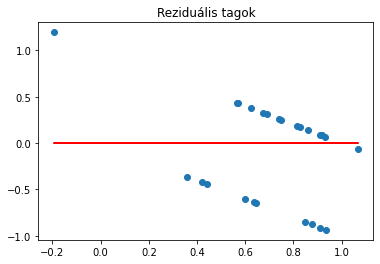

In [82]:
#Nézzük meg a reziduális tagokat

import matplotlib.pyplot as plt

plt.scatter(reg_pred, y_test-reg_pred)
plt.plot(reg_pred, [0 for i in range(reg_pred.shape[0])], c="red") #0-vonal
plt.title("Reziduális tagok")
plt.axis
plt.show

In [83]:
#R^2 és SSR
SST = np.sum(np.power(y_test-np.mean(y_test),2))
SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
R2 = round(SSR/SST,2)
R2

0.31

In [84]:
#másik: kerekítsük a becsült értékeket

for i in range(reg_pred.shape[0]):
    reg_pred[i] = round(reg_pred[i],0)

rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),2)
print("RMSE:", rmse_rounded)
lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),2)
print(round(sklearn.metrics.accuracy_score(y_test, reg_pred),2))

RMSE: 0.57
0.68


In [85]:
#lineáris regresszió összesen:
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

Linear regression:
- RMSE: 0.54 
- R2: 0.31 
- RMSE after rounding: 0.57 
- Accuracy after rounding: 0.68


### Eredmények összesítve

In [86]:
#összes teljes mindenes
#összesítve kNN
print(f'kNN with Mahalanobis:')
print(f'- Optmial number of neighbours: {knn_mahal_grid_search.best_params_} \n- Accuracy: {knn_mahal}')
print(f'kNN with Euclidean:')
print(f'- Optimal number of neighbours: {knn_eu_grid_search.best_params_} \n- Accuracy: {knn_eu}')
print("SVM:")
print(f'- Accuracy: {SVM_acc}')
print("Logistic Regression:")
print(f'- Accuracy: {log_acc}')
print("Naive Bayes:")
print(f'- Accuracy: {bayes_acc}')
print("Linear regression:")
print(f'- RMSE: {rmse} \n- R2: {R2} \n- RMSE after rounding: {rmse_rounded} \n- Accuracy after rounding: {lin_acc}')

kNN with Mahalanobis:
- Optmial number of neighbours: {'classifier__n_neighbors': 13, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6
kNN with Euclidean:
- Optimal number of neighbours: {'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'} 
- Accuracy: 0.6
SVM:
- Accuracy: 0.68
Logistic Regression:
- Accuracy: 0.6
Naive Bayes:
- Accuracy: 0.52
Linear regression:
- RMSE: 0.54 
- R2: 0.31 
- RMSE after rounding: 0.57 
- Accuracy after rounding: 0.68


# PCA

In [87]:
#főkomponens analízissel
#nézzük, mennyi főkomponenssel lesz a legjobb. (pl a logisztikus regresszió)
from sklearn.decomposition import PCA

scores = []

for i in range(2,11):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    neigh = KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(m=X_train.astype(float), rowvar=False)})
    neigh = neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    scores.append(round(sklearn.metrics.accuracy_score(y_test, y_pred),2))
    
scores

[0.28, 0.44, 0.52, 0.52, 0.64, 0.56, 0.44, 0.44, 0.4]

In [88]:
#főkomponenses logreg
from sklearn.decomposition import PCA
projected = PCA(4).fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)

logreg = OneVsRestClassifier(LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 10000)).fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "macro"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "macro"),2)}')

Accuracy: 0.56
Precision: 0.58
Recall: 0.58


In [89]:
#nézzük meg, hogy főkompononensenként hogy változnak a különböző algoritmusok eredménymutatói, és rakjuk dataframe-be!
PCA_scores = pd.DataFrame({"Főkomponensek száma":[], "Gradient Boosting Acc.":[], "Naive Bayes Acc.":[], "Logreg Acc.":[], "SVM Acc.":[], "Linreg RMSE":[], "Linreg R2":[], 
                           "Linreg RMSE kerekített":[], "Linreg Acc kerekített":[]})


for i in range(1,9):
    projected = PCA(i).fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(projected, label, test_size=0.3, random_state=0)
    
    from sklearn import preprocessing
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    X_train = quantile_transformer.fit_transform(X_train)
    X_test = quantile_transformer.transform(X_test)
    
    ### OPTIMALIZÁLÁS
    
    # Logreg
    
    pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
    param_grid = {'classifier__C':[i*0.05 for i in range(1,100)], 'classifier__solver':['sag','saga']}

    log_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    log_grid_search.fit(X_train, y_train)
    cv_score = log_grid_search.best_score_
    log_acc = round(log_grid_search.score(X_test, y_test),4)
    
    # Naive Bayes 
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),4)

    # SVM
    
    pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
    param_grid = {'classifier__C':[i*0.1 for i in range(1,50)], 'classifier__kernel':['linear','poly','rbf']}

    SVM_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    SVM_grid_search.fit(X_train, y_train)
    cv_score = SVM_grid_search.best_score_
    SVM_acc = round(SVM_grid_search.score(X_test, y_test),4)
    
    # GradBoost
    
    pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
    param_grid = {'classifier__learning_rate':[0.01*i for i in range(1,50)],
                  'classifier__n_estimators':[5*i for i in range(1,10)], 'classifier__criterion':['squared_error','friedman_mse'],
                  'classifier__max_depth':[3,4,5]}

    grad_grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=stratified_kfold,
                                   n_jobs=-1)


    grad_grid_search.fit(X_train, y_train)
    cv_score = grad_grid_search.best_score_
    grad_acc = round(grad_grid_search.score(X_test, y_test),4)
    
    # Linreg

    reg = LinearRegression().fit(X_train,y_train)
    reg_pred = reg.predict(X_test)
    
    rmse = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    
    SST = np.sum(np.power(y_test-np.mean(y_test),2))
    SSR = np.sum(np.power(reg_pred-np.mean(y_test),2))
    R2 = round(SSR/SST,4)
    R2
    
    for j in range(reg_pred.shape[0]):
        reg_pred[j] = round(reg_pred[j],0)

    rmse_rounded = round(np.power(np.sum(np.power(y_test - reg_pred, 2))/reg_pred.shape[0],0.5),4)
    lin_acc = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    reg_pred_rounded = round(sklearn.metrics.accuracy_score(y_test, reg_pred),4)
    
    
    #új sor a dataframe-be
    new_row = {"Főkomponensek száma":str(i), "Gradient Boosting Acc.":grad_acc, "Naive Bayes Acc.":bayes_acc ,"Logreg Acc.":log_acc, "SVM Acc.":SVM_acc, "Linreg RMSE":rmse, "Linreg R2":R2, 
               "Linreg RMSE kerekített":rmse_rounded, "Linreg Acc kerekített":reg_pred_rounded}
    PCA_scores = PCA_scores.append(new_row, ignore_index=True)

D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (56). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (56). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (56). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (56). n_quantiles is set to n_samples.
  warnings.warn(
D:\anaconda3\envs\otthoni\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of

In [90]:
PCA_scores

,Főkomponensek száma,Gradient Boosting Acc.,Naive Bayes Acc.,Logreg Acc.,SVM Acc.,Linreg RMSE,Linreg R2,Linreg RMSE kerekített,Linreg Acc kerekített
0,1,0.56,0.56,0.60,0.56,0.4847,0.1559,0.6633,0.56
1,2,0.56,0.56,0.52,0.48,0.4892,0.1677,0.6633,0.56
2,3,0.56,0.56,0.52,0.56,0.4908,0.1945,0.6633,0.56
3,4,0.56,0.56,0.56,0.56,0.5205,0.3001,0.6325,0.60
4,5,0.56,0.56,0.56,0.56,0.5118,0.2937,0.6325,0.60
5,6,0.52,0.52,0.48,0.56,0.5105,0.2324,0.6325,0.60
6,7,0.56,0.60,0.52,0.52,0.5212,0.2481,0.6633,0.56
7,8,0.48,0.36,0.44,0.52,0.5916,0.3725,0.7483,0.44


# Legjobb modellek (nincs kedvem legörgetni)

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC


# Vegyészmérnökök 3 csop: lineáris regresszió (3-as PCA-val)


# Biomérnökök 3 csop: lineáris regresszió (3-as PCA-val)



# Vegyészmérnök 2 csop: SVM


# Biomérnökök 2 csop: SVM